In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

READ DATA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Data = pd.read_csv('drive/MyDrive/ML2022/sensor_readings_2.csv')
D=Data.to_numpy()
dim=np.shape(D)
print(dim)
DF=np.copy(D)

(5456, 3)


In [5]:
DF = np.where(DF == 'Move-Forward' , 0, DF)
DF = np.where(DF == 'Sharp-Right-Turn', 1, DF)
DF = np.where(DF == 'Slight-Left-Turn' , 2, DF)
DF = np.where(DF == 'Slight-Right-Turn', 3, DF)

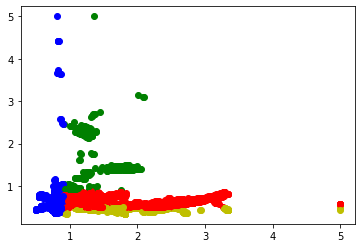

In [17]:
fig, ax = plt.subplots()
for i in range(np.shape(DF)[0]):
  if DF[i,2]== 0:
    ax.plot(DF[i,0],DF[i,1],'ro')
  elif DF[i,2]== 1:
    ax.plot(DF[i,0],DF[i,1],'bo')
  elif DF[i,2]== 2:
    ax.plot(DF[i,0],DF[i,1],'go')
  elif DF[i,2]== 3:
    ax.plot(DF[i,0],DF[i,1],'yo')

In [6]:
dim=np.shape(DF)
print(dim)
il=round(0.40*dim[0])
i=np.random.permutation(dim[0])
X=DF[i[0:il],0:dim[1]-1]
Y=DF[i[0:il],dim[1]-1]
Y=Y.astype('int')
print(Y[0:10])
print(X[0:10,:])
XT=DF[i[il+1:dim[0]],0:dim[1]-1]
YT=DF[i[il+1:dim[0]],dim[1]-1]
YT=YT.astype('int')


(5456, 3)
[1 1 1 1 1 1 2 0 1 1]
[[0.632 0.765]
 [0.82 0.822]
 [0.791 0.684]
 [0.844 0.661]
 [0.823 0.893]
 [0.87 0.485]
 [1.329 2.657]
 [2.159 0.567]
 [0.658 0.521]
 [0.549 0.784]]


In [8]:
YT=YT.astype('int')

EDA

NORMALIZE DATA

In [7]:
scalerX = preprocessing.MinMaxScaler()
X = scalerX.fit_transform(X)
XT = scalerX.transform(XT)

MODEL SELECTION (HYPERPARAMETER TUNING)

In [ ]:
grid = {'C':        np.logspace(-6,4,10),
        'kernel':   ['rbf'],
        'gamma':    np.logspace(-6,4,10)}
MS = GridSearchCV(estimator = SVC(),
                  param_grid = grid,
                  scoring = 'balanced_accuracy',
                  cv = 10,
                  verbose = 0)
H = MS.fit(X,Y)

TRAIN MODEL

In [ ]:
M = SVC(C = H.best_params_['C'],
        kernel = H.best_params_['kernel'],
        gamma = H.best_params_['gamma'])
M.fit(X,Y)

SVC(C=10000.0, gamma=59.94842503189421)

TEST SET

In [ ]:
YF = M.predict(XT)
confusion_matrix(YT,YF)

array([[332,   1,   0,   2],
       [  0, 314,   0,   0],
       [  1,   0,  44,   0],
       [  0,   0,   0, 123]])

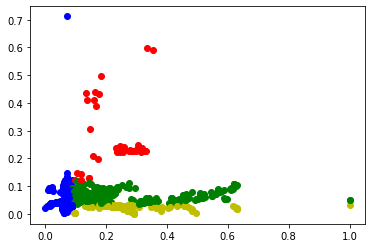

In [ ]:
fig, ax = plt.subplots()
for i in range(np.shape(YF)[0]):
  if YF[i]==YT[i] and YT[i]==1:
    ax.plot(XT[i,0],XT[i,1],'bo')
  elif YF[i]==YT[i] and YT[i]==0:
    ax.plot(XT[i,0],XT[i,1],'go')
  elif YF[i]==YT[i] and YT[i]==2:
    ax.plot(XT[i,0],XT[i,1],'ro')
  elif YF[i]==YT[i] and YT[i]==3:
    ax.plot(XT[i,0],XT[i,1],'yo')

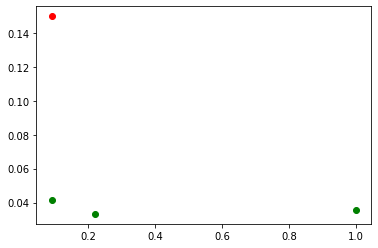

In [ ]:
fig, ax = plt.subplots()
for i in range(np.shape(YF)[0]):
  if YF[i]!=YT[i] and YT[i]==1:
    ax.plot(XT[i,0],XT[i,1],'bo')
  elif YF[i]!=YT[i] and YT[i]==0:
    ax.plot(XT[i,0],XT[i,1],'go')
  elif YF[i]!=YT[i] and YT[i]==2:
    ax.plot(XT[i,0],XT[i,1],'ro')
  elif YF[i]!=YT[i] and YT[i]==3:
    ax.plot(XT[i,0],XT[i,1],'yo')

TREE

In [8]:
maxDepth=3
grid = {'min_samples_leaf': [8,16,32,64,96,128]}
MS = GridSearchCV(estimator = DecisionTreeClassifier(),
                  param_grid = grid,
                  scoring = 'neg_mean_absolute_error',
                  cv = 10,
                  verbose = 0)
H = MS.fit(X,Y)
M = DecisionTreeClassifier(min_samples_leaf=H.best_params_['min_samples_leaf'],
                           max_depth=maxDepth)
M.fit(X,Y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=8)

In [9]:
text_representation = tree.export_text(M)
print(text_representation)

|--- feature_0 <= 0.09
|   |--- class: 1
|--- feature_0 >  0.09
|   |--- feature_1 <= 0.03
|   |   |--- class: 3
|   |--- feature_1 >  0.03
|   |   |--- feature_1 <= 0.12
|   |   |   |--- class: 0
|   |   |--- feature_1 >  0.12
|   |   |   |--- class: 2



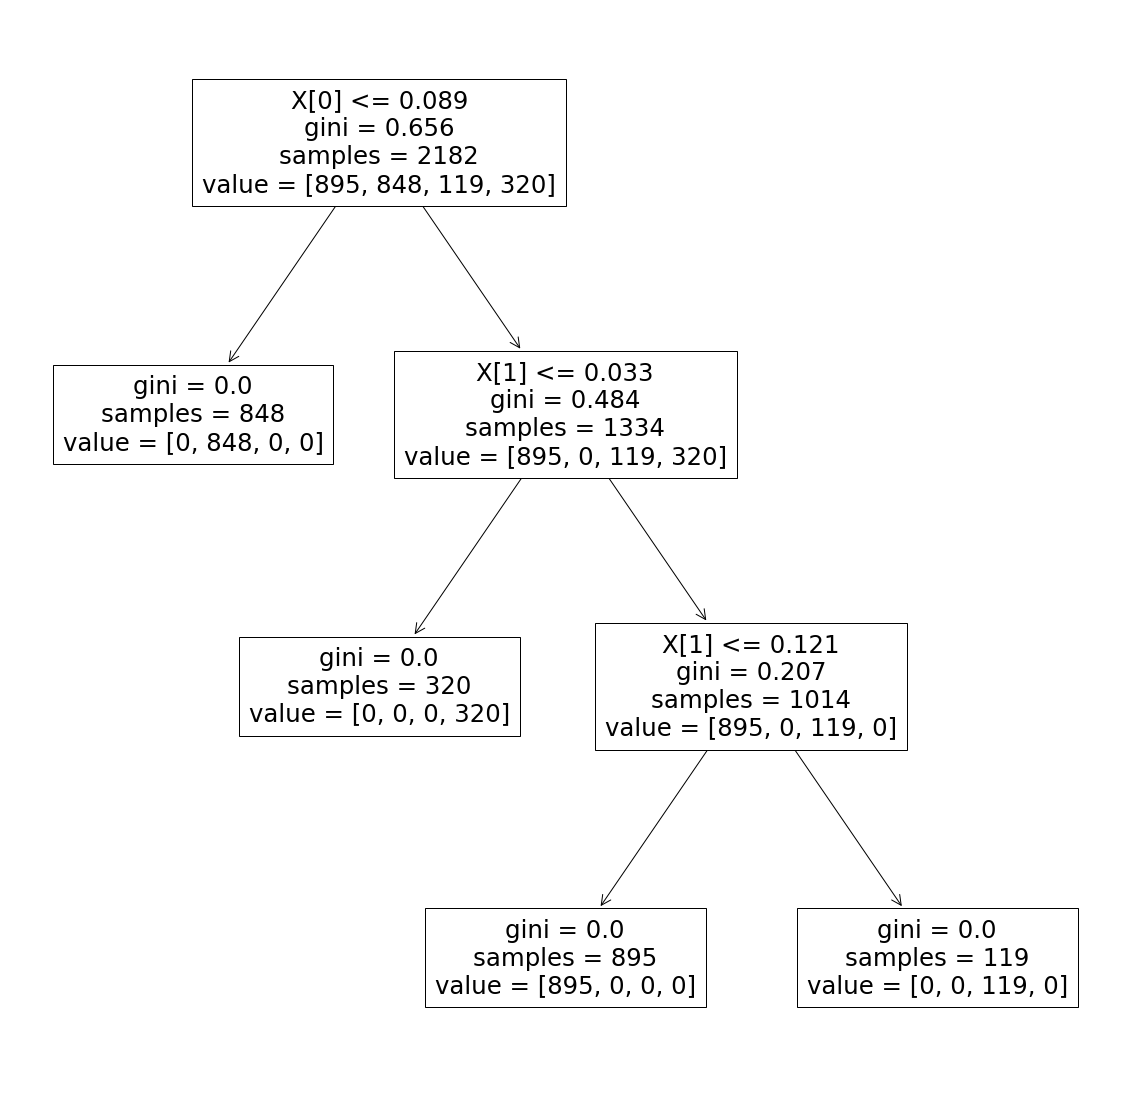

In [10]:
fig = plt.figure(figsize=(20,20))
_ = tree.plot_tree(M)

In [11]:
YF = M.predict(XT)
confusion_matrix(YT,YF)

array([[1307,    3,    0,    0],
       [   0, 1248,    0,    0],
       [   1,    0,  208,    0],
       [   0,    1,    0,  505]])